In [1]:
import os
import random

from typing import Union, Iterable, Sized, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import logging
import torchvision
import torchvision.transforms as transforms
from torch.distributions.uniform import Uniform
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [2]:
os.environ["WANDB_NOTEBOOK_NAME"] = "nam_wandb.ipynb"

import wandb
wandb.login()

wandb: Currently logged in as: yuvalzehavi22 (yuvalzehavi_22). Use `wandb login --relogin` to force relogin


True

In [3]:
# Ensure deterministic behavior
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Define the Data Loading and Model

In [4]:
def get_data(num_exp=10, in_features=5):
    # Simulate independent variables, x1,...,x5 from a Uniform distribution on [−1, 1]
    X = Uniform(-1, 1).sample((num_exp, in_features))

    y = X[:, 0] + 0.5*(3*(X[:, 1]**2)-1) + 0.5*(X[:, 2]**3)
    y = y.reshape(-1, 1)

    return X, y


def make_loader(X, y, batch_size):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

#batch_size=len(train_dataset)

In [5]:
def truncated_normal_(tensor, mean: float = 0., std: float = 1.):
    """
    Initializes a tensor with values from a truncated normal distribution
    """
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

# ActivationLayer Class
class ActivationLayer(torch.nn.Module):
    """
    Abstract base class for layers with weights and biases
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__()
        
        self.weight = torch.nn.Parameter(torch.empty((in_features, out_features)))
        self.bias = torch.nn.Parameter(torch.empty(in_features))

    def forward(self, x):
        raise NotImplementedError("abstract method called")


class ExULayer(ActivationLayer):
    """
    Custom layer using exponential activation with weight and bias initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        truncated_normal_(self.weight, mean=4.0, std=0.5)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x): 
        exu = (x - self.bias) @ torch.exp(self.weight)
        output = torch.clip(exu, 0, 1)
        
        if 0:
            print('ExULayer_weights:', self.weight.detach().cpu().numpy())
            print('ExULayer Normalization L1\n:', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ExULayer Normalization L2\n:',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


class ReLULayer(ActivationLayer):
    """
    Custom layer using ReLU activation with Xavier weight initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        torch.nn.init.xavier_uniform_(self.weight)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x):
        output = F.relu((x - self.bias) @ self.weight)
        
        if 0:
            print('ReLULayer_weights:', self.weight.detach().cpu().numpy())
            print('ReLULayer Normalization L1:\n', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ReLULayer Normalization L2:\n',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


# FeatureNN Class
class FeatureNN(torch.nn.Module):
    """
    Neural network for individual features
    """
    def __init__(self,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 dropout: float = .5,
                 latent_var_dim: int = 1,
                 ):
        super().__init__()
        
        # First (shallow) layer
        self.shallow_layer = shallow_layer(1, shallow_units)
        
        # Hidden layers
        self.hidden_layers = torch.nn.ModuleList()
        in_units = shallow_units
        for out_units in hidden_units:
            self.hidden_layers.append(hidden_layer(in_units, out_units))
            in_units = out_units  # Update in_units to the output of the last layer
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(p=dropout)
        
        # Output linear layer
        self.output_layer = torch.nn.Linear(in_units, latent_var_dim, bias=False)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = x.unsqueeze(1)
        
        # Pass through the shallow layer
        x = self.shallow_layer(x)
        #x = self.dropout(x)
        
        # Pass through each hidden layer with dropout
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.dropout(x)
            
        # Final output layer
        x = self.output_layer(x)
        
        return x


# Neural Additive Model (NAM) Class
class NeuralAdditiveModel(torch.nn.Module):
    """
    Combines multiple feature networks, each processing one feature, with dropout and bias
    """
    def __init__(self,
                 input_size: int,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 feature_dropout: float = 0.,
                 hidden_dropout: float = 0.,
                 latent_var_dim: int = 1,
                 ):
        super().__init__()
        
        self.input_size = input_size

        if isinstance(shallow_units, list):
            assert len(shallow_units) == input_size
        elif isinstance(shallow_units, int):
            shallow_units = [shallow_units for _ in range(input_size)]

        self.feature_nns = torch.nn.ModuleList([
            FeatureNN(shallow_units=shallow_units[i],
                      hidden_units=hidden_units,
                      shallow_layer=shallow_layer,
                      hidden_layer=hidden_layer,
                      dropout=hidden_dropout,
                      latent_var_dim=latent_var_dim)
            for i in range(input_size)
        ])
        self.feature_dropout = torch.nn.Dropout(p=feature_dropout)
        self.bias = torch.nn.Parameter(torch.zeros(1))

    def forward(self, x):
        f_out = torch.cat(self._feature_nns(x), dim=-1)
        f_out = self.feature_dropout(f_out)
        output = f_out.sum(axis=-1) + self.bias
        
        if 0:
            print('final output', output)
            print('f_out', f_out)
        return output, f_out

    def _feature_nns(self, x):
        return [self.feature_nns[i](x[:, i]) for i in range(self.input_size)]

In [6]:
# Loss function for regression
def feature_loss(fnn_out, lambda_=0.):
    return lambda_ * (fnn_out ** 2).sum() / fnn_out.shape[1]

def penalized_mse(logits, truth, fnn_out, feature_penalty=0.0):
    feat_loss = feature_loss(fnn_out, feature_penalty)
    mse_loss = F.mse_loss(logits.view(-1), truth.view(-1))
    loss = mse_loss+feat_loss
    return loss

# Define Training Logic

In [40]:
def train(model, loader, criterion, optimizer, config):

    # Run training and track with wandb
    total_batches = len(loader) * config['epochs']
    example_ct = 0  # number of examples seen
    batch_ct = 0
    loss_history = []
    for epoch in tqdm(range(config['epochs'])):
        if epoch % 200 == 1:
            # avoid overfit, but allow enough steps for fit
            X, y = get_data(num_exp=config['num_exp'], in_features=config['in_features'])
            loader = make_loader(X, y, batch_size=config['batch_size'])
            
        epoch_loss_history = []
        for _, (X, y) in enumerate(loader):

            loss = train_batch(X, y, model, optimizer, criterion)
            batch_ct += 1
            epoch_loss_history.append(loss)
#             # Report metrics every 5th batch
#             if ((batch_ct + 1) % 5) == 0:
#                 print(f"Epoch {epoch} | Batch {batch_ct + 1} | Total Loss: {loss:.5f}")

        avg_loss = sum(epoch_loss_history) / len(loader)
        loss_history.append(avg_loss)
    
        if epoch%100==0:
            print(f"Epoch {epoch} | Total Loss: {avg_loss:.5f}")
        
    return loss_history
        
def train_batch(X, y, model, optimizer, criterion):
    X, y = X.to(device), y.to(device)
    # Forward pass
    logits, fnns_out = model(X)
    
    loss = criterion(logits, y, fnns_out, feature_penalty=0.0001)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss


In [41]:
# def train(model, loader, criterion, optimizer, config):
#     # Tell wandb to watch what the model gets up to: gradients, weights, and more!
#     wandb.watch(model, criterion, log="all", log_freq=10)

#     # Run training and track with wandb
#     total_batches = len(loader) * config.epochs
#     example_ct = 0  # number of examples seen
#     batch_ct = 0
#     for epoch in tqdm(range(config.epochs)):
#         for _, (X, y) in enumerate(loader):

#             loss = train_batch(X, y, model, optimizer, criterion)
#             example_ct +=  len(X)
#             batch_ct += 1

#             # Report metrics every 25th batch
#             if ((batch_ct + 1) % 25) == 0:
#                 train_log(loss, example_ct, epoch)
                

# def train_batch(X, y, model, optimizer, criterion):
#     X, y = X.to(device), y.to(device)
    
#     # Forward pass
#     outputs = model(X)
#     loss = criterion(outputs, y)
    
#     # Backward pass
#     optimizer.zero_grad()
#     loss.backward()

#     # Step with optimizer
#     optimizer.step()

#     return loss


# def train_log(loss, example_ct, epoch):
#     # Where the magic happens
#     wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
#     print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

# Define the Experiment

In [55]:
# define experiment
config = dict(
    epochs=2000,
    batch_size=2048,
    learning_rate=0.01,
    num_exp = 5000,
    in_features = 5,
    shallow_units=20,
    hidden_units=(64, 32),
    feature_dropout=0.2,
    hidden_dropout=0.1,
    latent_dim=1,
    seed=123,
    dataset="Uniform_distribution",
    architecture="NAM")

In [56]:
config['latent_dim']

1

In [57]:
def make(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_data(num_exp=config['num_exp'], in_features=config['in_features'])
    train_loader = make_loader(X, y, batch_size=config['batch_size'])


    # Make the model
    model = NeuralAdditiveModel(input_size= config['in_features'],
                     shallow_units= config['shallow_units'],
                     hidden_units= config['hidden_units'],
                     shallow_layer = ExULayer,
                     hidden_layer = ReLULayer,
                     feature_dropout = config['feature_dropout'],
                     hidden_dropout = config['hidden_dropout'],
                     latent_var_dim = config['latent_dim'],           
                     ).to(device)

    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=0.00001
                                )
    
    return model, train_loader, criterion, optimizer

# Define the Pipeline

In [58]:
from torchsummary import summary

# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make(config)
print(model)

# Print a detailed summary of the model
summary(model, input_size=(config['in_features'],))

NeuralAdditiveModel(
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (shallow_layer): ExULayer()
      (hidden_layers): ModuleList(
        (0): ReLULayer()
        (1): ReLULayer()
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (output_layer): Linear(in_features=32, out_features=1, bias=False)
    )
    (1): FeatureNN(
      (shallow_layer): ExULayer()
      (hidden_layers): ModuleList(
        (0): ReLULayer()
        (1): ReLULayer()
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (output_layer): Linear(in_features=32, out_features=1, bias=False)
    )
    (2): FeatureNN(
      (shallow_layer): ExULayer()
      (hidden_layers): ModuleList(
        (0): ReLULayer()
        (1): ReLULayer()
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (output_layer): Linear(in_features=32, out_features=1, bias=False)
    )
    (3): FeatureNN(
      (shallow_layer): ExULayer()
      (hidden_layers): ModuleList(
        (0): ReLULayer()
        (1): ReLU

<ipython-input-4-a6f4ed6a94d9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 0 | Total Loss: 15.07332


<ipython-input-4-a6f4ed6a94d9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))


Epoch 100 | Total Loss: 0.29429
Epoch 200 | Total Loss: 0.26565
Epoch 300 | Total Loss: 0.24702
Epoch 400 | Total Loss: 0.25101
Epoch 500 | Total Loss: 0.24552
Epoch 600 | Total Loss: 0.24450
Epoch 700 | Total Loss: 0.24334
Epoch 800 | Total Loss: 0.24130
Epoch 900 | Total Loss: 0.23452
Epoch 1000 | Total Loss: 0.24180
Epoch 1100 | Total Loss: 0.23570
Epoch 1200 | Total Loss: 0.23386
Epoch 1300 | Total Loss: 0.23140
Epoch 1400 | Total Loss: 0.23384
Epoch 1500 | Total Loss: 0.23753
Epoch 1600 | Total Loss: 0.22962
Epoch 1700 | Total Loss: 0.23581
Epoch 1800 | Total Loss: 0.23981
Epoch 1900 | Total Loss: 0.22752


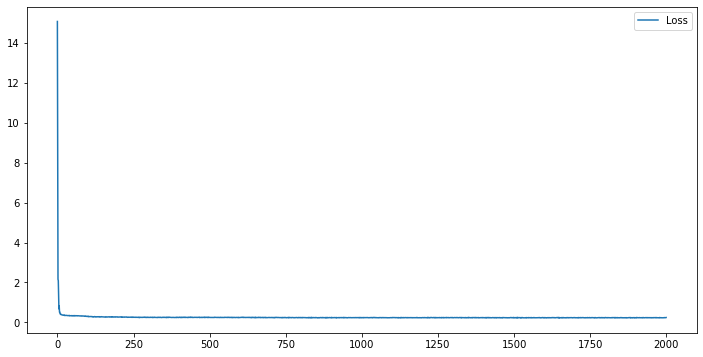

In [59]:
# and use them to train the model
loss_history = train(model, train_loader, criterion, optimizer, config)
loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

plt.figure(figsize=(12, 6))
plt.plot(loss_history_np)
plt.legend(['Loss'])
plt.show()

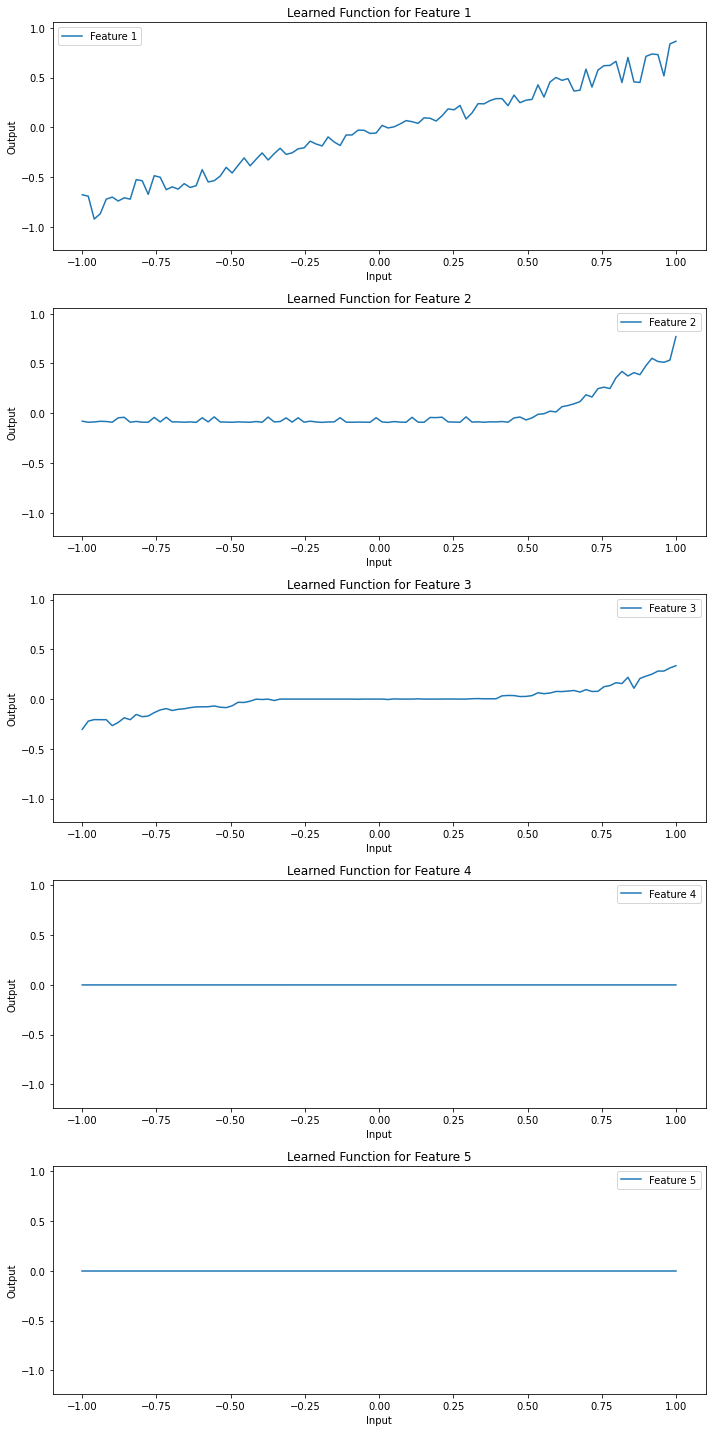

In [63]:
# Generate input values for plotting
x_values = torch.linspace(-1, 1, 100).reshape(-1, 1)  # 100 points between -1 and 1

# Plot learned functions
fig, axes = plt.subplots(config['in_features'],1, figsize=(10,20))

feature_output_max = [] 
feature_output_min = [] 
for i in range(config['in_features']):
    with torch.no_grad():
        feature_input = x_values
        feature_output = model.feature_nns[i](feature_input[:, 0]).cpu().numpy()
    feature_output_max.append(max(feature_output)) 
    feature_output_min.append(min(feature_output))
    
for i in range(config['in_features']):
    with torch.no_grad():
        axes[i].plot(x_values.cpu().numpy(), model.feature_nns[i](feature_input[:, 0]).cpu().numpy(), label=f'Feature {i+1}')
        axes[i].set_title(f'Learned Function for Feature {i+1}')
        axes[i].set_xlabel('Input')
        axes[i].set_ylabel('Output')
        axes[i].set_ylim([min(feature_output_min)*1.3, max(feature_output_max)*1.3])
        axes[i].legend()

plt.tight_layout()
plt.show()

In [10]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="Train NAM", config=hyperparameters):
        print('wandb started...')
        # access all HPs through wandb.config, so logging matches execution
        config = wandb.config

        # make the model, data, and optimization problem
        model, train_loader, criterion, optimizer = make(config)
        print(model)

        # and use them to train the model
        train(model, train_loader, criterion, optimizer, config)

    return model

# Run

In [11]:
model = model_pipeline(config)

MailboxError: transport failed